In [19]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LogFormatter 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import yaml

In [20]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

In [21]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

In [25]:
df['FiscalYear'] = df['MissionDate'].copy()
df.set_index('MissionDate', drop=False, inplace=True)
df.index.name = 'FiscalYear'

# Grouping records by exact date, fiscal year, MissionID,
# removal or transfer status, unique pickup/dropoff, juvenile status.
# Can't group by nationality here or it splits flights up and obscures trends
g = df.groupby([pd.Grouper(freq='AS-OCT'),
                'MissionDate',
                'R-T',
                'PULOC',
                'DropLoc',
                'air_LatitudeDecimalDegrees',
                'air_LongitudeDecimalDegrees',
                'air2_LatitudeDecimalDegrees',
                'air2_LongitudeDecimalDegrees'])

In [31]:
flights = g[['AlienMasterID']].nunique().reset_index()

In [32]:
flights.tail()

,FiscalYear,MissionDate,R-T,PULOC,DropLoc,air_LatitudeDecimalDegrees,air_LongitudeDecimalDegrees,air2_LatitudeDecimalDegrees,air2_LongitudeDecimalDegrees,AlienMasterID
42976,2018-10-01,2018-12-05,T,KIWA,KAEX,33.307833,-111.655472,31.327,-92.548,40
42977,2018-10-01,2018-12-05,T,KMCI,KAEX,39.297000,-94.714000,31.327,-92.548,5
42978,2018-10-01,2018-12-05,T,KMSP,KAEX,44.880000,-93.217000,31.327,-92.548,24
42979,2018-10-01,2018-12-05,T,KOMA,KAEX,41.302000,-95.894000,31.327,-92.548,5
42980,2018-10-01,2018-12-05,T,KBRO,KAEX,25.907000,-97.426000,31.327,-92.548,1


In [33]:
flights.set_index('MissionDate', inplace=True)

In [34]:
flights.head()

,FiscalYear,R-T,PULOC,DropLoc,air_LatitudeDecimalDegrees,air_LongitudeDecimalDegrees,air2_LatitudeDecimalDegrees,air2_LongitudeDecimalDegrees,AlienMasterID
MissionDate,,,,,,,,,
2010-10-01,2010-10-01,R,KAEX,MHLM,31.327000,-92.548000,15.452,-87.923,97
2010-10-01,2010-10-01,R,KBFL,KSAN,35.433000,-119.057000,32.733,-117.189,13
2010-10-01,2010-10-01,R,KCSG,MSLP,32.516333,-84.938861,13.441,-89.056,33
2010-10-01,2010-10-01,R,KDEN,KHRL,39.858000,-104.667000,26.228,-97.654,42
2010-10-01,2010-10-01,R,KELP,KHRL,31.807000,-106.378000,26.228,-97.654,46


In [30]:
# table.columns = ['year', 'R-T', 'pickup_airport', 'dropoff_airport', 'passengers', 'flights']
# all_kbfi = (table['pickup_airport'] == 'KBFI') | (table['dropoff_airport'] == 'KBFI')
# table.to_csv('../output/flight_summary.csv.gz', index=False, compression='gzip', encoding='utf-8', sep='|')

In [57]:
# flights = table
# flights = table[all_kbfi]
# flights = pd.read_csv('../output/flight_summary.csv.gz', compression='gzip', sep='|')
# flights = pd.read_csv('../output/guatemala_transfers.csv.gz', compression='gzip', sep='|')

In [59]:
# flights['pickup_airport'] = flights['pickup_airport'].str.upper()
# flights['dropoff_airport'] = flights['dropoff_airport'].str.upper()
# flights['pickup_airport'] = flights['PULOC'].str.upper()
# flights['dropoff_airport'] = flights['DropLoc'].str.upper()

In [36]:
flights_loc = set(pd.concat([flights['PULOC'], flights['DropLoc']]))

In [37]:
bad_airports = ['KKBL']

In [38]:
flights = flights[~flights['PULOC'].isin(bad_airports)]
flights = flights[~flights['DropLoc'].isin(bad_airports)]

In [63]:
# airports = pd.read_csv('../../share/hand/GlobalAirportDatabase.csv.gz', compression='gzip', sep='|')

In [39]:
# airports.head()

In [65]:
# airports_loc = set(airports['ICAOCode'])

In [66]:
# airports.set_index('ICAOCode', inplace=True)

In [67]:
# airports_missing_loc = ['FLKK', 'FWKI', 'KABQ', 'VTBS']

In [68]:
# airports = airports[~airports.index.isin(['FLKK', 'FWKI', 'KABQ', 'VTBS'])]

In [69]:
# additional_airports = pd.read_csv('../../share/hand/locations.csv', quotechar='"')

In [70]:
# additional_airports.columns = ['ICAOCode', 'CountryISO', 'State', 'City', 'LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']
# additional_airports.set_index('ICAOCode', inplace=True)
# additional_airports.head()

,CountryISO,State,City,LatitudeDecimalDegrees,LongitudeDecimalDegrees
ICAOCode,,,,,
BKPR,KS,Pristina,Slatina,42.572778,21.035833
EYVI,LT,Vilnius,Vilnius,54.636944,25.287778
FKYS,CM,Nsimalen,Nsimalen,3.722500,11.553333
FYWH,NaN,Windhoek,Windhoek,-22.486667,17.462500
GQNO,MR,Nouakchott,Nouakchott,18.310000,-15.969722


In [71]:
# missing_airports = list(flights_loc.difference(airports_loc))
# missing_airports.extend(airports_missing_loc)

In [40]:
# airports_2 = additional_airports[additional_airports.index.isin(missing_airports)].copy()

In [41]:
# airports_2.head()

In [42]:
# airports_2 = airports_2[['LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']]

In [43]:
# airports = pd.concat([airports, airports_2])

In [76]:
# arts_airports = list(set(df['PULOC'].append(df['DropLoc'])))

In [77]:
# airports_to_merge = airports[airports.index.isin(arts_airports)][['LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']]

# # 

In [78]:
# airports_to_merge.to_csv('../output/airports_to_merge.csv')

In [79]:
# airports.head()

,AirportName,Altitude,City,Country,IATACode,LatitudeDecimalDegrees,LatitudeDegrees,LatitudeDirection,LatitudeMinutes,LatitudeSeconds,LongitudeDecimalDegrees,LongitudeDegrees,LongitudeDirection,LongitudeMinutes,LongitudeSeconds
ICAOCode,,,,,,,,,,,,,,,
AYGA,GOROKA,1610.0,GOROKA,PAPUA NEW GUINEA,GKA,-6.082,6.0,S,4.0,54.0,145.392,145.0,E,23.0,30.0
AYLA,NaN,0.0,LAE,PAPUA NEW GUINEA,LAE,0.000,0.0,U,0.0,0.0,0.000,0.0,U,0.0,0.0
AYMD,MADANG,7.0,MADANG,PAPUA NEW GUINEA,MAG,-5.207,5.0,S,12.0,25.0,145.789,145.0,E,47.0,19.0
AYMH,MOUNT HAGEN,1643.0,MOUNT HAGEN,PAPUA NEW GUINEA,HGU,-5.826,5.0,S,49.0,34.0,144.296,144.0,E,17.0,46.0
AYNZ,NADZAB,73.0,NADZAB,PAPUA NEW GUINEA,LAE,-6.570,6.0,S,34.0,11.0,146.726,146.0,E,43.0,34.0


In [44]:
edges = flights[['PULOC', 'DropLoc']].values

In [45]:
g = nx.from_edgelist(edges)

In [46]:
len(g.nodes()), len(g.edges())

(221, 721)

/Users/philneff/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


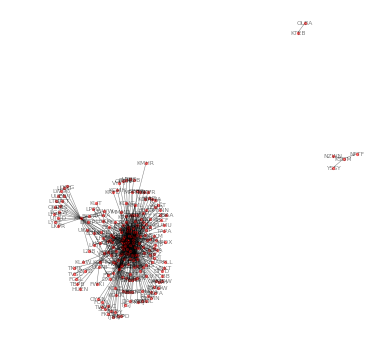

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

In [48]:
sg = next(nx.connected_component_subgraphs(g))

In [49]:
list(nx.connected_component_subgraphs(g))[1].nodes

NodeView(('OLBA', 'KTEB'))

In [50]:
list(nx.connected_component_subgraphs(g))[2].nodes

NodeView(('NZWN', 'YSSY', 'KSDM', 'NFTF'))

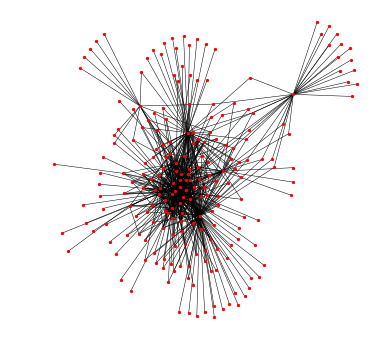

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(sg, ax=ax, with_labels=False,
                 node_size=5, width=.5)
ax.set_axis_off()

In [53]:
airport_dict['KBFI']

{'AirportName': 'Boeing Field King County International Airport',
 'LatitudeDecimalDegrees': 47.53,
 'LongitudeDecimalDegrees': -122.302}

In [57]:
pos = {airport: (v['LongitudeDecimalDegrees'], v['LatitudeDecimalDegrees'])
       for airport, v in
       airport_dict.items()}

In [59]:
# Dropping unknown locations
pos_unknown = {k:v for k, v in pos.items() if v == (0.0, 0.0)}

In [75]:
# This is a dumb workaround to avoid issue with concatenating objects with different categories
# Do something to set each airport code column to include all airports instead?
flights['pickup'] = flights['PULOC'].astype(str)
flights['dropoff'] = flights['DropLoc'].astype(str)

In [91]:
airport_vars = pd.read_csv('../output/all_airport_vars.csv', index_col='Unnamed: 0')

In [92]:
airport_vars.head()

,airport_name,monthly_dropoff_avg,monthly_dropoff_mission_avg,monthly_pickup_avg,monthly_pickup_mission_avg,removal_percent,total_unique,transfer_percent,unique_dropoff_missions,unique_dropoffs,unique_pickup_missions,unique_pickups,unique_removals,unique_transfers
BKPR,Pristina International Airport,0.06,0.05,NaN,NaN,100.0,4,0.0,3,4,0,0,4,0
DAAG,Houari Boumediene Airport,3.00,1.00,NaN,NaN,100.0,3,0.0,1,3,0,0,3,0
DFFD,Ouagadougou Airport,5.00,1.00,NaN,NaN,100.0,5,0.0,1,5,0,0,5,0
DGAA,Kotoka International Airport,3.76,0.09,NaN,NaN,100.0,350,0.0,8,350,0,0,350,0
DIAP,Port Bouet Airport,0.32,0.06,NaN,NaN,100.0,31,0.0,6,31,0,0,31,0


In [93]:
airport_vars.loc['KBFI', 'removal_percent']

32.37

In [76]:
pickup_totals = flights.groupby('pickup')['AlienMasterID'].sum()
dropoff_totals = flights.groupby('dropoff')['AlienMasterID'].sum()

In [78]:
passenger_totals = pd.concat([pickup_totals, dropoff_totals])

In [79]:
passenger_total = pd.Series(passenger_totals[icao].sum() for icao in sg.nodes)

In [111]:
removal_percent = pd.Series(airport_vars.loc[icao, 'removal_percent'] * 100 for icao in sg.nodes)

In [132]:
deg = nx.degree(sg)
sizes = [passenger_totals[icao].sum() / 500 for icao in sg.nodes]

In [133]:
passenger_total.index = sg.nodes

In [134]:
top_10_list = list(passenger_total.sort_values(ascending=False).head(10).index)

In [135]:
top_10_list

['KAEX',
 'MGGT',
 'KIWA',
 'KHRL',
 'KBRO',
 'KELP',
 'MHLM',
 'MSLP',
 'KSAN',
 'KSAT']

In [136]:
labels = {icao: icao if passenger_totals[icao].sum() >= 35000 else ''
          for icao in sg.nodes}
no_labels = {icao: '' for icao in sg.nodes}
top_10 = {icao: icao if icao in top_10_list else ''
          for icao in sg.nodes}

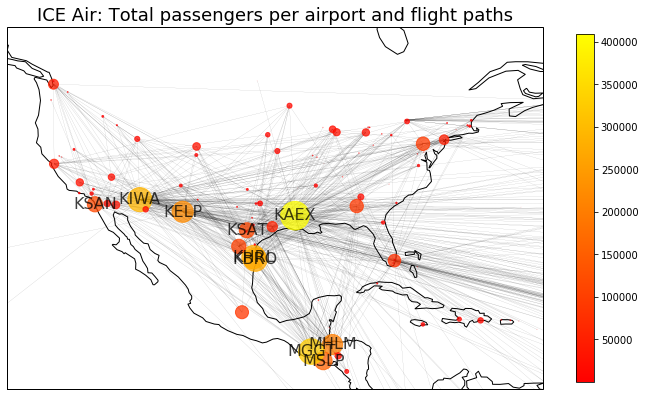

In [142]:
# Map projection
crs = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 10, 50])
# Global
# ax.set_extent([-180, 180, -60, 90])

cmap = plt.cm.autumn

nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=.75,
                 width=.075,
                 node_size=sizes,
                 node_color=passenger_total,
                 labels=top_10,
                 pos=pos,
                 cmap=cmap)

vmin = passenger_total.min()
vmax = passenger_total.max()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, shrink=.8)
plt.title("ICE Air: Total passengers per airport and flight paths", size=18)
plt.show()

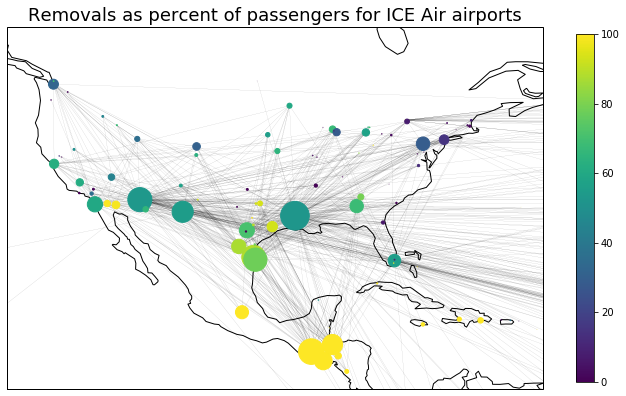

In [141]:
# Map projection
crs = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 10, 50])
# Global
# ax.set_extent([-180, 180, -60, 90])

cmap = plt.cm.viridis

nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=1,
                 width=0.05,
                 node_size=sizes,
                 node_color=removal_percent,
                 labels=no_labels,
                 pos=pos,
                 cmap=cmap)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=100))
sm._A = []
plt.colorbar(sm, shrink=.8)
plt.title("Removals as percent of passengers for ICE Air airports", size=18)
plt.show()

# Choropleth

/Users/philneff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


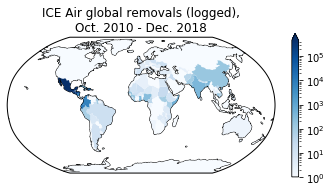

In [100]:
cmap = mpl.cm.Blues
# Countries is a dictionary of {"country_name": number of users}, for example
countries = df[df['R-T'] == 'R'].groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique().to_dict()

min_passengers = float(min(countries.values()))
max_passengers = float(max(countries.values()))
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()

for country in shpreader.Reader(countries_shp).records():
    name = country.attributes['NAME_LONG'].upper()
    try:
        num_passengers = countries[name]
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                    facecolor=cmap(np.log(num_passengers)/np.log(max_passengers)))
    except:
        num_passengers = 0
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                    facecolor=cmap(num_passengers))
        pass

# formatter = LogFormatter(labelOnlyBase=False) 
    
sm = plt.cm.ScalarMappable(cmap=cmap,norm=colors.LogNorm(vmin=1, vmax=max_passengers))
sm._A = []
plt.colorbar(sm, ax=ax, shrink=.66, extend='max')

plt.title('ICE Air global removals (logged),\nOct. 2010 - Dec. 2018')

plt.savefig('../output/removal_choropleth.png', transparent=True, dpi=900)

## Directed graph

In [144]:
G = nx.DiGraph()

In [158]:
edges = flights[['PULOC', 'DropLoc']].values

In [218]:
weights = flights.groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().reset_index()

In [220]:
for row in weights.values:
    G.add_edge(row[0], row[1], weight=row[2])

In [221]:
len(G.edges)

888

In [222]:
len(G.nodes)

221

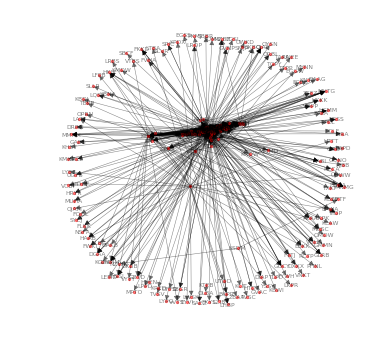

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(G, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

In [255]:
weights = [c for (u, v, c) in G.edges.data('weight', default=0)]

In [273]:
passenger_total = pd.Series(passenger_totals[icao].sum() for icao in G.nodes)

In [274]:
sizes = [passenger_totals[icao].sum() / 500 for icao in G.nodes]

In [275]:
max(weights)

91714

In [276]:
G.get_edge_data('KBFI', 'KIWA')

{'weight': 9991}

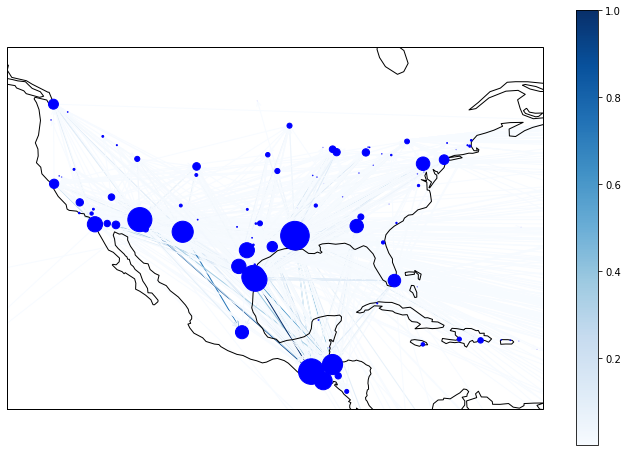

In [282]:
# Map projection
crs = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 10, 50])

M = G.number_of_edges()
edge_colors = [weight / max(weights) for weight in weights]
edge_alphas = 1

nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, ax=ax, node_size=sizes, arrowstyle='->',
                               arrowsize=10,
                               edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues,
                               width=1,
                               transform=ccrs.Geodetic())
# set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

# ax = plt.gca()
# ax.set_axis_off()
plt.show()

In [271]:
G.neighbors('KBFI')